# **Variáveis do sistema e importações**
Todas bibliotecas utilizadas:


*   OS: Leitura dos arquivos/pastas
*   OpenCV: Processamento de imagens, leitura das imagens, salvar as imagens
*   SciPY: Gerenciamento de pixels das imagens
*   NumPY: Arrays
*   JSON: Salvar os dados com label
*   SkImage: Processamento de imagens (Watershed, centróide, momentos estatistícos)

Largura e altura das imagens foram salvas em 500





In [ ]:
!pip install opencv-python-headless numpy scikit-learn pandas matplotlib scipy scikit-image pandas sklearn

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import graycomatrix, graycoprops, peak_local_max
from skimage.measure import moments, moments_central, moments_normalized, moments_hu, centroid
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## Ambiente

Nesse caso, utilizamos o google drive para armazenar todos os arquivos.

In [ ]:
from google.colab import drive
drive.mount('files')

Drive already mounted at files; to attempt to forcibly remount, call drive.mount("files", force_remount=True).


Caso você não queira utilizar o Google drive, modifique as seguintes variáveis para descrever o caminho dos arquivos:

In [ ]:
pasta_imagens = './files/MyDrive/pid/images'
pasta_destino = 'images_processed'
results_file = './files/MyDrive/pid/results.json'

# **Segmenta as imagens**
Ele segmenta as folhas em N imagens, que são as folhas separadas. E também recria a imagem original (com todas as folhas) onde mostra os números das folhas para posteriormente poder categorizar as folhas presentes em cada imagem para o treinamento.
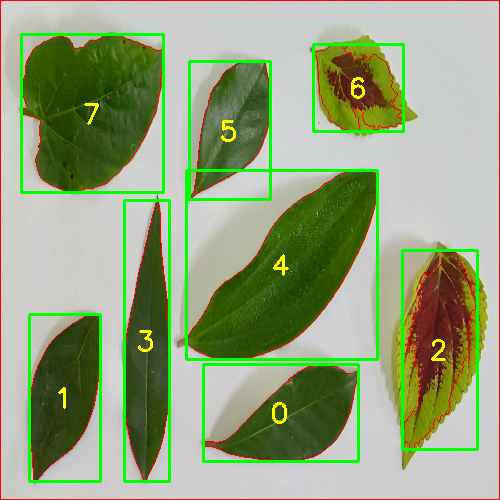

O código acima é utilizado para segmentar folhas em uma imagem. Inicialmente, a imagem é convertida para tons de cinza e redimensionada para um tamanho padrão. Depois disso, um desfoque gaussiano é aplicado à imagem para reduzir o ruído e tornar mais suaves as transições de cores. O método de Otsu é utilizado para realizar a binarização da imagem, isto é, transformar todos os pixels em preto ou branco. Uma transformação de distância é aplicada na imagem, que proporciona a distância de cada pixel até o pixel mais próximo de cor diferente. Com isso, a imagem é segmentada em regiões de provável fundo (background) e provável objeto (foreground). Estas regiões são então dilatadas para melhorar a segmentação.

A partir das regiões definidas, são estabelecidos marcadores para identificar áreas desconhecidas, que não são claramente parte do fundo ou do objeto. O algoritmo de watershed é aplicado nessa etapa, considerado um dos mais eficazes para a segmentação de imagens. Nesse processo, as regiões são "inundadas" a partir dos marcadores, até que as regiões de fundo e objeto se encontrem, estabelecendo fronteiras bem definidas. Os contornos das folhas são então identificados e as folhas individuais são extraídas e armazenadas. Para facilitar a visualização, o código também desenha retângulos ao redor de cada folha e numera cada uma delas. O objetivo de todo este processo é separar individualmente cada folha presente na imagem, mesmo que elas estejam se tocando ou sobrepostas. Esse tipo de procedimento é muito útil em diversas áreas, como biologia, para análise e contagem de folhas, ou em agricultura, para detecção e diagnóstico de doenças em plantações.

In [ ]:
altura = 500
largura = 500

def segment_leaves(imagem):
    imagem_processada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem_processada = cv2.resize(imagem_processada, (altura, largura))
    blurred = cv2.GaussianBlur(imagem_processada, (5, 5), 0)

    # Otsu's thresholding
    _, thresholded = cv2.threshold(
        blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Distance transform
    dist_transform = cv2.distanceTransform(thresholded, cv2.DIST_L2, 3)

    _, sure_fg = cv2.threshold(
        dist_transform, 0.2*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Dilation for improving markers
    kernel = np.ones((2, 2), np.uint8)
    sure_fg = cv2.dilate(sure_fg, kernel, iterations=1)

    # Define the unknown region as the areas that are not clearly part of the background or the foreground
    _, sure_bg = cv2.threshold(
        dist_transform, 1.5*dist_transform.min(), 255, 0)
    sure_bg = np.uint8(sure_bg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    imagem = cv2.resize(imagem, (altura, largura))

    markers = cv2.watershed(imagem, markers)
    imagem[markers == -1] = [0, 0, 255]

    # Convert the markers to binary image
    binary = np.where((markers > 1), 255, 0).astype('uint8')

    # Apply a morphological erosion to create a gap between touching leaves
    kernel = np.ones((2, 2), np.uint8)

    # Find contours in the binary image
    contours, _ = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    segmented_leaves = []
    contador = 0

    imagem_copy = imagem.copy()
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        leaf = imagem[y:y+h, x:x+w]
        segmented_leaves.append(leaf.copy())

        centro_x = int(x + w/2)
        centro_y = int(y + h/2)

        cv2.rectangle(imagem_copy, (x, y),
                      (x + w, y + h), (0, 255, 0), 2)

        texto = str(contador)
        tamanho_texto, _ = cv2.getTextSize(
            texto, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        texto_x = int(centro_x - tamanho_texto[0]/2)
        texto_y = int(centro_y + tamanho_texto[1]/2)
        cv2.putText(imagem_copy, texto, (texto_x, texto_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

        contador += 1

    return segmented_leaves, imagem_copy

# **Leitura das imagens**
Processa as imagens dentro de uma pasta, que armazena os caminhos para todas as imagens presentes na página, para cada imagem também é salvo a imagem processada (exemplo anterior) e as folhas internas

In [ ]:
def processar_imagens_pasta(pasta):
    imagens_processadas = []
    imagens = []
    caminhos = []

    for nome_arquivo in os.listdir(pasta):
        if nome_arquivo.endswith('.jpg') or nome_arquivo.endswith('.jpeg') or nome_arquivo.endswith('.png') or nome_arquivo.endswith('.bmp'):
            caminho = os.path.join(pasta, nome_arquivo)
            caminhos.append(caminho)

    caminhos.sort()
    for caminho in caminhos:
        imagem = cv2.imread(caminho)

        if imagem is not None:
            leaflets, image_processed = segment_leaves(imagem)
            imagens_processadas.append(leaflets)
            imagens.append(image_processed)

    return imagens_processadas, imagens, caminhos

# **Salvar as imagens**
Esta função é responsável por armazenar as imagens com os números (posição no *array* dentro de cada imagem) de identificação das folhas e com as caixas indicando as folhas

In [ ]:
def criar_pasta(nome_pasta):
    if not os.path.exists(nome_pasta):
        os.makedirs(nome_pasta)
        print(f"A pasta '{nome_pasta}' foi criada com sucesso.")
    else:
        print(f"A pasta '{nome_pasta}' já existe.")

def salvar_imagens_processadas(imagens, caminhos, pasta_destino):
    # Cria a pasta de destino se ela não existir
    criar_pasta(pasta_destino)

    for i in range(len(imagens)):
        # Extrai o nome do arquivo da imagem
        nome_arquivo = os.path.basename(caminhos[i])
        caminho_destino = os.path.join(pasta_destino, nome_arquivo)

        # Salva a imagem processada
        cv2.imwrite(caminho_destino, imagens[i])

# **Extração das características**
Função que pega as características de cada folha, sendo usadas:


*   Dissimilaridade
*   Energia
*   Homogeneidade
*   Área
*   Perímetro
*   Momentos estatísticos
*   Correlação
*   Média das cores


In [ ]:
def extract_features(leaf):
    gray = cv2.cvtColor(leaf, cv2.COLOR_BGR2GRAY)
    median_color = np.median(leaf, axis=(0, 1))

    glcm = graycomatrix(
        gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    # Calculate shape features
    m = moments(gray)
    cr, cc = centroid(m)  # center of mass coordinates
    m_central = moments_central(gray, [cr, cc])
    m_normalized = moments_normalized(m_central)
    hu_moments = moments_hu(m_normalized)

    # Calculate size features
    contours, _ = cv2.findContours(
        gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contours[0])
    perimeter = cv2.arcLength(contours[0], True)

    # Package features into a dictionary
    features = {
        'median_color': median_color.tolist(),
        'dissimilarity': dissimilarity.tolist(),
        'homogeneity': homogeneity.tolist(),
        'energy': energy.tolist(),
        'correlation': correlation.tolist(),
        'hu_moments': hu_moments.tolist(),
        'area': area,
        'perimeter': perimeter,
    }

    return features


# **Data augmentation**
Ele gera imagens maiores e vai as rotacionando em 90º em 90º graus até dar 360º e com as imagens rotacionadas ele gera novas imagens mudando o brilho e contraste.
Isso auxilia para que a IA tenha maior conjunto de dataset

In [ ]:
def generate_variants(imagem):
    variants = []

    for i in range(0, 400, 100):
        if i == 0:
            resized = imagem.copy()
        else:
            resized = cv2.resize(imagem, (i, i), interpolation=cv2.INTER_AREA)
            variants.append(resized)
        rotated = resized.copy()
        images_rotated = []
        for i in range(0, 360, 90):
            rotated = cv2.rotate(rotated, cv2.ROTATE_90_CLOCKWISE)
            variants.append(rotated)
            images_rotated.append(rotated)

        # Altera o brilho da imagem
        for rotated in images_rotated:
            brightness = rotated.copy()
            for i in range(0, 45, 10):
                brightness = cv2.convertScaleAbs(rotated, beta=i)
                variants.append(brightness)

        for rotated in images_rotated:
            brightness = rotated.copy()
            for i in range(0, 35, 10):
                brightness = cv2.convertScaleAbs(rotated, beta=-i)
                variants.append(brightness)

        for rotated in images_rotated:
            contrast = rotated.copy()
            for i in range(5, 10, 1):
                float_value = i/10
                contrast = cv2.convertScaleAbs(rotated, alpha=float_value)
                variants.append(contrast)

    return variants

# **Função para checar se as folhas foram segmentadas corretamente**
Valida se as segmentações gerou o mesmo número de folhas esperados para cada imagem

In [ ]:
def test(imagens_processadas):
    images_test = [8, 8, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 7,
                   7, 7, 7, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

    for i, resultado in enumerate(imagens_processadas):
        res = len(resultado)
        if res != images_test[i]:
            print(
                f"Número de folhas na imagem {i+1}: {res} -> {images_test[i]}")


# **Categorização das folhas (Labeling manual)**
A função mostra o caminho da imagem e pede a categorização para as folhas presentes nela (0 - Folhado | 1 - Araçá | 2 - Quaresmeira | 3 - Pessegueiro | 4 - Coleus | 5 - Uva do mato), com isso ele extrai as características, gera as variantes das folhas e salva em um JSON que servirá para treinar o modelo de predição

In [ ]:
def extrair_caracteristicas(imagens_processadas, caminhos):
    results = []
    names_leaflet = ["folhado", "araca",
                     "quaresmeira", "pessegueiro", "coleus", "uva"]

    for i, imagem in enumerate(imagens_processadas):
        results_local = []
        for j, contorno in enumerate(imagem):
            features = extract_features(contorno)
            results_local.append({
                "nome": '',
                "features": features
            })

        print("0 - Folhado | 1 - Araçá | 2 - Quaresmeira | 3 - Pessegueiro | 4 - Coleus | 5 - Uva")
        nome_arquivo = os.path.basename(caminhos[i])
        caminho_destino = os.path.join(pasta_destino, nome_arquivo)

        while True:
            values = input(f"{caminho_destino} ({len(imagem)}): ")

            values = values.split(" ")

            if len(values) == len(imagem):
                break
            # Verifica se todas as entradas são válidas
            else:
                for value in values:
                    if value not in ["0", "1", "2", "3", "4", "5"]:
                        print("Valor inválido!")
            print("Quantidade de valores inválida!")
        for j, value in enumerate(values):
            results_local[j]["nome"] = names_leaflet[int(value)]
        results.extend(results_local)

        for j, result in enumerate(results_local):
            variants = generate_variants(imagem[j])
            for variant in variants:
                features = extract_features(variant)
                results.append({
                    "nome": result["nome"],
                    "features": features
                })

    # Salva os resultados em um TXT
    with open("./results.json", "w") as f:
        # Transforma em JSON
        f.write(json.dumps(results,
                           indent=4,
                           separators=(',', ': '),
                           ))


# **Geração de resultados**
Passa por todas as funções apresentadas e com isso gerando as folhas processadas com suas respectivas label e características

In [ ]:
# Armazena imagens processadas e caminhos dos arquivos
imagens_processadas, imagens, caminhos = processar_imagens_pasta(
    pasta_imagens)

# Salva as imagens processadas na pasta de destino
salvar_imagens_processadas(imagens, caminhos, pasta_destino)

test(imagens_processadas)
# Extrai quantidade de folhas da imagem
resultados = extrair_caracteristicas(imagens_processadas, caminhos)


## Modelo classificador

Pré-processamentos dos dados. Basicamente o arquivo gerado anteriormente é compactado em um data frame.

In [ ]:
# Load data from the JSON file
with open(f"{results_file}", 'r') as file:
    data = json.load(file)

# Show the first few records
data[:3]

In [ ]:
# Function to flatten the feature dictionary
def flatten_features(data):
    flattened_data = []
    for d in data:
        flattened = {}
        flattened['nome'] = d['nome']
        for key, value in d['features'].items():
            if isinstance(value, list) and isinstance(value[0], list):
                for i, v in enumerate(value[0]):
                    flattened[f'{key}_{i}'] = v
            elif isinstance(value, list):
                for i, v in enumerate(value):
                    flattened[f'{key}_{i}'] = v
            else:
                flattened[key] = value
        flattened_data.append(flattened)
    return flattened_data

# Flatten the data and convert it to a pandas DataFrame
flattened_data = flatten_features(data)
df = pd.DataFrame(flattened_data)

df.head()

,nome,median_color_0,median_color_1,median_color_2,dissimilarity_0,dissimilarity_1,dissimilarity_2,dissimilarity_3,homogeneity_0,homogeneity_1,...,correlation_3,hu_moments_0,hu_moments_1,hu_moments_2,hu_moments_3,hu_moments_4,hu_moments_5,hu_moments_6,area,perimeter
0,coleus,16.0,105.0,94.0,8.512496,8.224638,6.835034,10.104095,0.266755,0.270746,...,0.937299,0.007395,0.000033,3.045619e-07,5.320794e-07,2.111625e-13,3.050452e-09,-3.589468e-14,8694.0,390.0
1,araca,18.0,47.0,36.0,7.556532,9.148597,5.649616,6.562476,0.291415,0.280247,...,0.972461,0.011585,0.000108,1.742739e-06,2.245506e-06,4.438895e-12,2.331399e-08,-1.684779e-13,10404.0,442.0
2,pessegueiro,40.0,63.0,49.0,7.663903,7.727380,4.147327,7.677645,0.279141,0.284478,...,0.960687,0.016177,0.000238,5.714217e-06,6.300561e-06,3.780241e-11,9.728737e-08,-4.271420e-13,13572.0,584.0
3,uva,27.0,63.0,49.0,6.275524,7.566664,5.420181,6.285054,0.277792,0.256387,...,0.978017,0.008252,0.000043,4.161042e-07,7.387386e-07,4.071656e-13,4.846829e-09,-4.439438e-14,24676.0,646.0
4,pessegueiro,33.0,100.0,164.0,6.671681,5.899404,3.936826,7.768523,0.325973,0.329792,...,0.959756,0.011580,0.000117,1.879467e-06,2.209684e-06,4.501990e-12,2.386192e-08,-1.004322e-13,29355.0,808.0


import numpy as np
from google.colab import autoviz
df_3099228357627438430 = autoviz.get_df('df_3099228357627438430')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3099228357627438430, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4231180250292397939 = autoviz.get_df('df_4231180250292397939')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4231180250292397939, *['median_color_0'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8090239524298505033 = autoviz.get_df('df_8090239524298505033')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8090239524298505033, *['median_color_1'], **{})
chart

import numpy as np
from google.colab import autoviz
df_9207942398773323832 = autoviz.get_df('df_9207942398773323832')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_9207942398773323832, *['median_color_2'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2358845313405401333 = autoviz.get_df('df_2358845313405401333')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2358845313405401333, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7615860979461913401 = autoviz.get_df('df_7615860979461913401')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7615860979461913401, *['median_color_0'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3231272951774967536 = autoviz.get_df('df_3231272951774967536')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3231272951774967536, *['median_color_1'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7308339016716123782 = autoviz.get_df('df_7308339016716123782')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7308339016716123782, *['median_color_2'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6649657572102413159 = autoviz.get_df('df_6649657572102413159')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_6649657572102413159, *['nome'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3476590783766731147 = autoviz.get_df('df_3476590783766731147')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_3476590783766731147, *[[['index', 'median_color_0'], ['median_color_0', 'median_color_1'], ['median_color_1', 'median_color_2'], ['median_color_2', 'dissimilarity_0']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_1616826007589860261 = autoviz.get_df('df_1616826007589860261')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_1616826007589860261, *['index', 'nome'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_9194815888707525296 = autoviz.get_df('df_9194815888707525296')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_9194815888707525296, *['median_color_0', 'nome'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_93455700172452861 = autoviz.get_df('df_93455700172452861')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_93455700172452861, *['median_color_1', 'nome'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_7276727200651415428 = autoviz.get_df('df_7276727200651415428')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_7276727200651415428, *['median_color_2', 'nome'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_846569562742663886 = autoviz.get_df('df_846569562742663886')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_846569562742663886, *['index', 'median_color_0', 'nome'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7611567450428273494 = autoviz.get_df('df_7611567450428273494')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7611567450428273494, *['index', 'median_color_1', 'nome'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7936432368751809943 = autoviz.get_df('df_7936432368751809943')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7936432368751809943, *['index', 'median_color_2', 'nome'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7113986864449429846 = autoviz.get_df('df_7113986864449429846')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7113986864449429846, *['index', 'dissimilarity_0', 'nome'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Assim, os nomes das folhas (a variável que será predita) é encodado, o dataset é dividido na proporção 80/20 para treinamento e teste, respectivamente e esses dados são usados para treinar um modelo do tipo MLP com 100 neurônios "ocultos".

In [ ]:
le = LabelEncoder()
df['nome'] = le.fit_transform(df['nome'])

# Separate features and target variable
X = df.drop('nome', axis=1)
y = df['nome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9684, 28), (2421, 28), (9684,), (2421,))

In [ ]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit on the training set and transform both the training and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show the first few rows of the scaled training set
X_train_scaled[:5, :]

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)
mlp.fit(X_train_scaled, y_train)

MLPClassifier(random_state=42)

Aqui, a única métrica utilizada para mensurar o modelo foi a **acurácia**. Porém, somente ela não é ideal para saber o quão preciso é o modelo, assim é necessário uma melhor análise nesse contexto.

In [ ]:
y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm, accuracy

(array([[261,   0,   0,   0,   0,   0],
        [  0, 373,   0,   0,   0,   0],
        [  0,   0, 507,   1,   0,   0],
        [  0,   0,   0, 412,   0,   0],
        [  0,   0,   0,   0, 445,   0],
        [  0,   0,   0,   0,   0, 422]]),
 0.9995869475423379)

## Validação

Por fim, o último passo foi apontar um diretório com imagens diferentes daquelas utilizadas para trenamento, a fim de validar o modelo.

In [ ]:
def validate(validation_dir):
    images_processed, _, paths = processar_imagens_pasta(validation_dir)
    for i, image_set in enumerate(images_processed):
        print(f"Arquivo: {os.path.basename(paths[i])}")
        print(f"Número de folhas: {len(image_set)}")

        counts = {}

        for leaf in image_set:
            features = extract_features(leaf)
            flattened_features = flatten_features([{'nome': '', 'features': features}])
            df = pd.DataFrame(flattened_features)
            X = df.drop('nome', axis=1)
            X_scaled = scaler.transform(X)
            prediction = mlp.predict(X_scaled)
            decoded_prediction = le.inverse_transform(prediction)
            if decoded_prediction[0] in counts:
                counts[decoded_prediction[0]] += 1
            else:
                counts[decoded_prediction[0]] = 1

        for leaf_name, count in counts.items():
            print(f"{leaf_name} ({count})")

        print("\n"*2)

validate("./validation")

Arquivo: IMG_20230504_090659.bmp
Número de folhas: 8
coleus (2)
araca (1)
pessegueiro (3)
uva (1)
folhado (1)



Arquivo: IMG_20230504_090748.bmp
Número de folhas: 8
coleus (2)
araca (1)
pessegueiro (3)
uva (1)
folhado (1)



Arquivo: IMG_20230504_090851.bmp
Número de folhas: 6
araca (1)
uva (2)
coleus (1)
quaresmeira (2)



Arquivo: IMG_20230504_090854.bmp
Número de folhas: 6
araca (1)
uva (2)
coleus (1)
quaresmeira (2)



Arquivo: IMG_20230504_090900.bmp
Número de folhas: 6
araca (1)
uva (2)
coleus (1)
quaresmeira (2)



Arquivo: IMG_20230504_090908.bmp
Número de folhas: 6
araca (1)
uva (2)
coleus (1)
quaresmeira (2)



Arquivo: IMG_20230504_091023.bmp
Número de folhas: 7
coleus (2)
uva (1)
pessegueiro (2)
quaresmeira (1)
araca (1)



Arquivo: IMG_20230504_091027.bmp
Número de folhas: 7
coleus (2)
uva (1)
pessegueiro (2)
quaresmeira (1)
araca (1)



Arquivo: IMG_20230504_091033.bmp
Número de folhas: 7
coleus (2)
uva (1)
pessegueiro (2)
quaresmeira (1)
araca (1)



Arquivo: IMG_202305